# <font color="red" size="+3"> **Voice Cloning with Tacotron 2 & WaveGlow**
___

#### Follow the steps, executing the cells in order, to use.

___

# <font color="pink"> **Preparation of the development environment**

In [1]:
#@markdown ## <font color="pink"> **1. Check the GPU** 👁️ </font>
#@markdown ---

# Check the GPU
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-3993319c-e497-2351-95b7-299b633661e2)


In [3]:
#@markdown ## <font color="pink"> **2. Mount your Google Drive.**
#@markdown ---

from google.colab import drive

# Google Drive Authentication
if not exists('/content/drive'):
    drive.mount('drive', force_remount=True)

Mounted at drive


In [4]:
#@markdown ## <font color="pink"> **3. Install Tacotron2 with ARPAbet.**
#@markdown ---

import os
from os.path import exists
%matplotlib inline

# Clone tacotron2
%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  print("Cloning justinjohn0306/TTS-TT2")
  !git clone https://github.com/justinjohn0306/ARPAtaco2.git TTS-TT2
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update
%cd /content/TTS-TT2/

# Downloading Tacotron2 requirements
print("Downloading tacotron2 requirements")
!pip install matplotlib numpy inflect scipy Unidecode pillow

# Download Gdown (Google Drive direct download of big files)
print("Downloading Gdown (Google Drive direct download of big files)")
!pip install git+https://github.com/wkentaro/gdown.git

# Bash script to install some other requirements
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq

# Bash script for download files
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh

# Install some other libraries
!pip install gdown
!pip install librosa
!pip install soundfile pygame
!pip install speechbrain SpeechRecognition
!pip install pydub

/content
Cloning justinjohn0306/TTS-TT2
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 89 (delta 2), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (89/89), 7.11 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/TTS-TT2
/content/TTS-TT2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-o8gg5z0z
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-o8gg5z0z
  Resolved https://github.com/wkentaro/gdown.git to commit 5c7507f02718048899b85d4010a6ed93316cbf27
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: fi

In [5]:
#@markdown ## <font color="pink"> **4. Download Tacotron2 pretrained model & the CMU Pronunciation Dictionary.**
import gdown

# Download NVIDIA's Tacotron2 model
tt2_pretrained = "https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
if not os.path.isfile("/content/TTS-TT2/pretrained_model"):
  print("Downloading tt2 pretrained")
  gdown.download(tt2_pretrained, "/content/TTS-TT2/pretrained_model", quiet=False)

# Download the pronunciation dictionary
if not os.path.isfile("/content/TTS-TT2/text/merged.dict.txt"):
  print("Applying cmudict patch")
  # !curl https://cdn.discordapp.com/attachments/820353681567907901/865742324084244480/tacotron2-cmudict-patch.zip -o /content/tacotron2-cmudict-patch.zip
  gdown.download("https://drive.google.com/uc?id=1xgtiHABttD4MTds4KUPjghXfLqvzln2_", "/content/tacotron2-cmudict-patch.zip", quiet=False)
  !unzip -o /content/tacotron2-cmudict-patch.zip -d /content/TTS-TT2/text/
  !mv /content/TTS-TT2/text/merged.dict.txt /content/TTS-TT2/

latest_downloaded = None

Downloading...
From (original): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
From (redirected): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA&confirm=t&uuid=5aa97be7-1846-417c-8105-4d4862d54ee5
To: /content/TTS-TT2/pretrained_model
100%|██████████| 113M/113M [00:01<00:00, 85.1MB/s]


Applying cmudict patch


Downloading...
From: https://drive.google.com/uc?id=1xgtiHABttD4MTds4KUPjghXfLqvzln2_
To: /content/tacotron2-cmudict-patch.zip
100%|██████████| 893k/893k [00:00<00:00, 34.0MB/s]

Archive:  /content/tacotron2-cmudict-patch.zip
  inflating: /content/TTS-TT2/text/cleaners.py  
  inflating: /content/TTS-TT2/text/cmudict.py  
  inflating: /content/TTS-TT2/text/LICENSE  
  inflating: /content/TTS-TT2/text/README  
  inflating: /content/TTS-TT2/text/__init__.py  
  inflating: /content/TTS-TT2/text/merged.dict.txt  


In [6]:
#@markdown ## <font color="pink"> **5. Import some libraries**

# For Divers
import os
import sys
import time
import glob
import gdown
import zipfile
import shutil
import datetime
import logging

# For Maths
import argparse
import random
import math
from math import e
import numpy as np
from numpy import finfo

# For visualization
import matplotlib.pylab as plt

# For Tensors & Dataset
import torch
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from distributed import apply_gradient_allreduce

# For Tacotron2 & Training
from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
from train import load_model

# For Audio
import wave
import IPython as ipd
from pydub import AudioSegment
from pydub.playback import play
from audio_processing import griffin_lim
# from denoiser import Denoiser
from scipy.io.wavfile import write
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
import librosa.display

# For Text
from text import text_to_sequence
import speech_recognition as sr
from torchtext.data import get_tokenizer
from collections import Counter
from wordcloud import WordCloud

# For Files
from google.colab import files, drive


# Remode Warning packages
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)
logging.getLogger('speechbrain').setLevel(logging.WARNING)

# Check the current path
directory_path = os.getcwd()
print(directory_path)


/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


/content/TTS-TT2


In [7]:
#@markdown ## <font color="pink"> **Implements some useful functions for environment preparation step**

#@markdown ---
#@markdown #### Quelques fonctions pour les **environment preparation**.
#@markdown  - <font color="orange">**download_from_google_drive**</font>
#@markdown  - <font color="orange">**clean_memory**</font>
#@markdown  - <font color="orange">**init_distributed**</font>
#@markdown  - <font color="orange">**prepare_directories_and_logger**</font>


# Download des fichiers from Google Drive
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

# Snippet pour Nettoyage RAM et GPU
def clean_memory():
    # Nettoyage de la mémoire du GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Nettoyage de la mémoire du CPU
    gc.collect()

# Initialise le mode Distribué
def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")

# Prepare les dossier et les logger
def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger



# <font color="pink"> **Data Collect and Processing**

In [8]:
#@markdown ## <font color="pink"> **1. Implements some useful functions for data preparation step** 📂


#@markdown ---
#@markdown #### Quelques fonctions pour les **datasets**.
#@markdown  - <font color="orange">**prepare_dataloaders**</font>
#@markdown  - <font color="orange">**check_dataset**</font>
#@markdown  - <font color="orange">**create_file_list_from_folder**</font>
#@markdown  - <font color="orange">**create_zip_file_from_folder**</font>
#@markdown  - <font color="orange">**save_file**</font>

# Prepare le Dataloader from hparams
def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

# Prepare le dataset from hparams
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# Create a file list from folder path: folder_path (string) -> items_list (list)
def create_file_list_from_folder(folder_path):
    items_list = [item for item in glob.glob(folder_path)]
    return items_list

# Create a Zip file from folder path
def create_zip_file_from_folder(folder_path, folder_name):
    !zip -r {folder_path}/{folder_name}.zip {folder_path}

# Save Text or Json file: filename (string), text (string) -> None
def save_file(text_path, text, type='txt'):
    with open(text_path, 'w', encoding='utf-8') as file:
        if type == 'json':
            json.dump(text, file, ensure_ascii=False, indent=4)
        else:
            file.write(text)


#@markdown ---
#@markdown #### Quelques fonctions pour les **traitement audio**.
#@markdown  - <font color="orange">**resample_audio**</font>
#@markdown  - <font color="orange">**convert_stereo_to_mono**</font>
#@markdown  - <font color="orange">**convert_bit_depth**</font>
#@markdown  - <font color="orange">**convert_audio_format**</font>
#@markdown  - <font color="orange">**create_mels**</font>

# Convert audio: Resample audio
def resample_audio(audio_waveform, orig_sample_rate, new_sample_rate):
    if orig_sample_rate != new_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=new_sample_rate)
        audio_waveform = resampler(audio_waveform)
    return audio_waveform

# Convert audio: Stereo to Mono
def convert_stereo_to_mono(audio_waveform):
    if audio_waveform.shape[0] > 1:
        audio_waveform = torch.mean(audio_waveform, dim=0, keepdim=True)
    return audio_waveform

# Convert audio: 16 Bits
def convert_bit_depth(waveform, bit_depth):
    if bit_depth == 16:
        waveform = (waveform * (2**15)).short()
    return waveform

# Format audio files for Tacotron2
def convert_audio_format(file_path, target_sample_rate=22050, bit_depth=16, source='mono'):
    # Load audio
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample for 22050 as needed
    waveform = resample_audio(waveform, sample_rate, target_sample_rate)

    # Convert to mono as needed
    waveform = convert_stereo_to_mono(waveform)

    # Convert to 16 bits as needed
    waveform = convert_bit_depth(waveform, bit_depth)

    # Save edited audio
    torchaudio.save(file_path, waveform, target_sample_rate)


#@markdown ---
#@markdown #### Quelques fonctions pour les **traitement textuel**.
#@markdown  - <font color="orange">**speech_to_text_from_file**</font>
#@markdown  - <font color="orange">**text_to_sequence**</font>
#@markdown  - <font color="orange">**text_to_tokens**</font>
#@markdown  - <font color="orange">**histogram_from_tokens**</font>
#@markdown  - <font color="orange">**histogram_from_phonems**</font>

# Speech to Text
def speech_to_text_from_file(audio_file, language='fr-FR'):
    # Initialiser le recognizer
    r = sr.Recognizer()
    text = ""

    # Utiliser le fichier audio comme source
    with sr.AudioFile(audio_file) as source:
        # Écouter le fichier audio
        audio = r.record(source)

        try:
            # Utiliser le recognizer pour convertir l'audio en texte
            text = r.recognize_google(audio, language=language)
            print("Le texte transcrit est : {}".format(text))
        except sr.UnknownValueError:
            # Gérer l'erreur si l'audio n'est pas compris
            print("Google Speech Recognition n'a pas pu comprendre l'audio")
        except sr.RequestError as e:
            # Gérer l'erreur si la requête échoue
            print("Impossible d'obtenir les résultats depuis Google Speech Recognition service; {0}".format(e))

    filename = audio_file.replace('wav', 'txt')  # .replace('item', 'text')
    print('filename: ', filename)
    with open(filename, 'w') as file:
        file.write(text)

    return text

# Conversion text to Sequences
def text_to_sequence(text):
    symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
    look_up = {s: i for i, s in enumerate(symbols)}
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

# Conversion Text to Tokens
def text_to_tokens(text):
    tokenizer = get_tokenizer("basic_english")
    tokens = tokenizer(text)
    return tokens

# Display an histogram from tokens
def histogram_from_tokens(phonemes, name='Phonems', title='Histogramme des Phonèmes ARPAbet'):
    %matplotlib inline
    # Compter la fréquence de chaque phonème
    phoneme_freq = Counter(phonemes)

    # Convertir en DataFrame pour faciliter la visualisation
    phoneme_freq_df = pd.DataFrame.from_dict(phoneme_freq, orient='index', columns=['Frequency'])

    # Trier par fréquence
    phoneme_freq_df = phoneme_freq_df.sort_values('Frequency', ascending=False)

    # Créer l'histogramme
    plt.figure(figsize=(12, 8))
    phoneme_freq_df.plot(kind='bar', legend=None)
    plt.title(title)
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

# Display an histogram from phonemes
def histogram_from_phonems(phonemes, name='Phonems', title='Histogramme des Phonèmes ARPAbet'):
    %matplotlib inline
    # Compter la fréquence de chaque phonème
    phoneme_freq = Counter(phonemes)

    # Convertir en DataFrame pour faciliter la visualisation
    phoneme_freq_df = pd.DataFrame.from_dict(phoneme_freq, orient='index', columns=['Frequency'])

    # Trier par fréquence
    phoneme_freq_df = phoneme_freq_df.sort_values('Frequency', ascending=False)

    # Créer l'histogramme
    plt.figure(figsize=(12, 8))
    phoneme_freq_df.plot(kind='bar', legend=None)
    plt.title(title)
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

# Create a phonem list
def phoneme_to_list(phonemes):
    import re
    pattern = r'[0-9]'

    # Remplace les accolades et les points
    phonem_list = phonemes.replace("} {", "@")
    phonem_list = phonem_list.replace("} . {", ".")
    phonem_list = phonem_list.replace("} .", "'.")
    phonem_list = phonem_list.replace("{", "'")
    phonem_list = phonem_list.replace(" ", "', '")
    phonem_list = phonem_list.replace("@", "', ' ', '")
    phonem_list = phonem_list.replace(".", "', '.', '")
    phonem_list = phonem_list.replace("}", "")


    # Enleve les chiffres
    phonem_list_new = []
    for i in [phonem_list]:
        new_i = re.sub(pattern, '', i)
        phonem_list_new.append(new_i)

    # Converti le string en list de strings avec quelques erreurs
    phonem_list_new_split = phonem_list_new[0].split()

    # Corrige ces erreurs
    new_list = []
    for i in phonem_list_new_split:
        new_i = i.replace("'", "").replace(",", "")
        new_list.append(new_i)

    # Crée une liste avec les elements uniques seulement
    phonem_list_unique = []
    for i in new_list:
        if i not in phonem_list_unique:
            phonem_list_unique.append(i)

    # Check if all ARPAbet phonems are present in my dataset
    phonem_list_arpabet = []
    for i in phonem_list_unique:
        if i in arpabet_phonemes:
            phonem_list_arpabet.append(i)

    return phonem_list, new_list, phonem_list_unique, phonem_list_arpabet


#@markdown ---
#@markdown #### Quelques fonctions pour le **Traitement des Spectrogrammes**.
#@markdown  - <font color="orange">**create_mels**</font>

# Create Mel Spectrogrammes from Signal
def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)

    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)

#@markdown  \

#@markdown ---
#@markdown #### Remplacer les fichiers dans TTS-TT2/filelists pas ceux de votre dataset.


In [11]:
#@markdown ## <font color="pink"> **2. Load your dataset.**

#@markdown ---

#@markdown #### **Audio processing**: Put audio files in the correct format (Sample Rate, Encodage & Chanels) i.e. <font color="orange">**22050, 16 bits, Mono**</font>. Otherwise, check the audio precessinf box in order to format them then normalize and remove the silences.

#@markdown  \

#@markdown #### **Download audio processing**: If the cache is enabled, the processed audio files will be archived and compressed into a zip file.

#@markdown  \

# Selection des traitements
audio_processing = True #@param {type:"boolean"}
archive_audio_processing = False #@param {type:"boolean"}

# Importation de Fichiers Audio depuis un fichier zip ou Google Drive
drive_path = "/content/data_cleaned.zip" #@param {type: "string"}
# drive_path = "/content/drive/My Drive/your_file" #@param {type: "string"}

# Vérification de l'Existence de Fichiers Audio :
if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

# Préparation d'un Script pour le Traitement Audio :
with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    ffmpeg -y -i /content/tempwav/srtmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

# Change de répertoire et supprime les espaces vide du chemin
%cd /content/TTS-TT2/wavs
drive_path = drive_path.strip()

# Verifie l'existence d'un fichier sur Google Drive
if drive_path:
   # Decompresser et importer les fichiers dans le dossier 'wavs'
    if os.path.exists(drive_path):
        print(f"\n\033[34m\033[1mAudio imported from Drive.\n\033[90m")
        if zipfile.is_zipfile(drive_path):
            !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs
        else:
            fp = drive_path + "/."
            !cp -a "$fp" "/content/TTS-TT2/wavs"
    # Si pas de fichier, demande à l'utilisateur d'en importer un
    else:
        print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
        print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
        uploaded = files.upload()

# Sinon, demande à l'utilisateur d'en importer un pour le decompresser et l'importer dans le dossier 'wavs'
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()
  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

# Resuctrure l'organisation des fichiers audios au besoin
if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt

# Traitement des Fichiers Audio Importés si demandé
if audio_processing:
  print(f"\n\033[37mMetadata removal and audio verification...")
  !mkdir /content/tempwav
  !bash /content/audios.sh

# Calcul de la Durée Totale des Fichiers Audio
totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    print('file_name: ', file_name)
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration
        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

# Compte le nombre de Fichiers Audio et la durée totale
wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")

# Archive et Zip les fichiers audios traités
if archive_audio_processing:
    print('Archive et Zip les fichiers audios traités')
    shutil.make_archive("/content/processedwavs", 'zip', '/content/TTS-TT2/wavs')
    files.download('/content/processedwavs.zip')

print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/wavs

Audio imported from Drive.

rm: cannot remove '/content/TTS-TT2/wavs/list.txt': No such file or directory

Metadata removal and audio verification...
file_name:  15.wav
file_name:  58.wav
file_name:  46.wav
file_name:  19.wav
file_name:  25.wav
file_name:  45.wav
file_name:  6.wav
file_name:  27.wav
file_name:  29.wav
file_name:  34.wav
file_name:  23.wav
file_name:  59.wav
file_name:  51.wav
file_name:  41.wav
file_name:  7.wav
file_name:  28.wav
file_name:  42.wav
file_name:  5.wav
file_name:  35.wav
file_name:  14.wav
file_name:  47.wav
file_name:  40.wav
file_name:  22.wav
file_name:  32.wav
file_name:  54.wav
file_name:  56.wav
file_name:  57.wav
file_name:  10.wav
file_name:  52.wav
file_name:  26.wav
file_name:  49.wav
file_name:  9.wav
file_name:  13.wav
file_name:  39.wav
file_name:  60.wav
file_name:  48.wav
file_name:  55.wav
file_name:  8.wav
file_name:  21.wav
file_name:  3.wav
file_name:  37.wav
file_name:  44.wav
file_name:  38.wav
file_name:  24.w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All set, please proceed.


In [12]:
#@markdown ## <font color="pink"> **3. Upload the transcript.** 📝
#@markdown #### The transcript must be a ``.TXT`` file formatted in ``UTF-8 without BOM.``


%cd /content/TTS-TT2/filelists/
!rm /content/TTS-TT2/filelists/list.txt

print("\n\033[34m\033[1mUpload your transcript(list)...")
listfn, length = files.upload().popitem()

if listfn != "list.txt":
  !mv "$listfn" list.txt


with open('list.txt', 'r') as f:
    lines = f.readlines()


new_lines = []
for line in lines:
    audio_file_path = '/content/TTS-TT2/' + line.split('|')[0]

    if os.path.exists(audio_file_path):
        new_lines.append(line)


with open('list.txt', 'w') as f:
    f.writelines(new_lines)

%cd /content/TTS-TT2/
print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/filelists

Upload your transcript(list)...


Saving list.txt to list.txt
/content/TTS-TT2

All set, please proceed.


In [13]:
#@markdown ## <b><font color="pink"> **5. Check the working cmudict patch**
%cd /content/TTS-TT2/
import text

# texte = 'the little bunny hopped through the forest looking for carrots.'
# print('Texte: ', text)
# print('Texte to Sequence: ', text.text_to_sequence("The little bunny hopped through the forest looking for carrots", ["cmudict_cleaners", "english_cleaners"]))
# print('Sequence to Texte: ', text.sequence_to_text(text.text_to_sequence("The little bunny hopped through the forest looking for carrots", ["cmudict_cleaners", "english_cleaners"])))

texte = "The little bunny hopped through the forest looking for carrots. \
Once upon a time, there was a magical kingdom in the clouds. \
The friendly bear waved hello to all the animals in the wood. \
Every night, the twinkling stars would tell stories in the sky. \
The rainbow appeared, showing all its beautiful colors. \
Ducks love to splash around in the pond during summer. \
The curious kitten found a ball of yarn and played all day. \
We can count the colorful balloons at the birthday party. \
Let’s go on a treasure hunt in the backyard. \
The brave astronaut took a spaceship to the moon. \
In the jungle, you can hear the lions roar loudly. \
The train chugged along, passing mountains and valleys. \
She built the tallest tower with her blocks. \
The little turtle carried his home on his back everywhere he went. \
On a sunny day, the flowers in the garden dance in the breeze. \
The wise old owl stayed awake to watch over the forest. \
Let’s make a big sand castle on the beach. \
The penguins waddle around on the ice, looking very funny. \
The friendly ghost says boo, but he’s not scary at all. \
Let's fly kites high in the sky on a windy day. \
The princess and the prince lived happily ever after. \
In autumn, the leaves turn orange, red, and yellow. \
The busy bees buzzed from flower to flower. \
Every morning, the rooster crows to wake up the farm. \
The little ants marched in line to carry their food. \
The fluffy cloud looked like a bunny in the sky. \
Let’s count the stars in the sky before bedtime. \
The frog leaped high to catch the flying bug. \
A big, round, yellow sun smiled down on the village. \
The funny monkey loves to swing from tree to tree. \
She found the most beautiful shell on the beach. \
The children played hide and seek in the park. \
Let's sing a song about happy little sunflowers. \
The tiny mouse sneaked out to find some cheese. \
The old pirate map led to a buried treasure chest. \
The dragon breathed fire but was friendly to everyone. \
The fairies danced under the moonlight. \
The wizard waved his wand and cast a magic spell. \
Let’s ride our bikes around the neighborhood. \
The young prince went on an adventure in the forest. \
Can you help me solve this fun puzzle? \
The rainbow fish had scales in all different colors. \
The clock struck twelve, and the mice ran up the clock. \
The little ducklings followed their mother in a line. \
She painted a beautiful picture with all her crayons. \
At night, the moon watches over our dreams. \
The superhero saved the day with courage and kindness. \
This phrase no doubt contained a wealth of sounds. \
Just keep examining every low bid quoted for zinc etchings. \
A quick movement of the enemy will jeopardize six gunboats. \
All questions asked by five watched experts amaze the judge. \
The box was thrown beside the parked truck. \
Enjoy the usual leisure, book and cushion, young fashion boy with vision. \
The five boxing wizards jump quickly. \
Fix problem quickly with galvanized jets. \
Heavy boxes perform quick waltzes and jigs. \
Pack my box with five dozen liquor jugs."

tokens = text_to_tokens(texte)
sequence = text.text_to_sequence(texte, ["cmudict_cleaners", "english_cleaners"])
phonemes = text.sequence_to_text(text.text_to_sequence(texte, ["cmudict_cleaners", "english_cleaners"]))

print('Texte: ', texte)
print('Text to Tokens: ', tokens)
print('Texte to Sequence: ', sequence)
print('Sequence to Texte: ', phonemes)

/content/TTS-TT2
Texte:  The little bunny hopped through the forest looking for carrots. Once upon a time, there was a magical kingdom in the clouds. The friendly bear waved hello to all the animals in the wood. Every night, the twinkling stars would tell stories in the sky. The rainbow appeared, showing all its beautiful colors. Ducks love to splash around in the pond during summer. The curious kitten found a ball of yarn and played all day. We can count the colorful balloons at the birthday party. Let’s go on a treasure hunt in the backyard. The brave astronaut took a spaceship to the moon. In the jungle, you can hear the lions roar loudly. The train chugged along, passing mountains and valleys. She built the tallest tower with her blocks. The little turtle carried his home on his back everywhere he went. On a sunny day, the flowers in the garden dance in the breeze. The wise old owl stayed awake to watch over the forest. Let’s make a big sand castle on the beach. The penguins waddle

In [14]:
#@markdown ## <b><font color="pink"> **4. Check if all ARPAbet phonems are present in my dataset**

arpabet_phonemes = ["AA", "AE", "AH", "AO", "AW", "AY", "EH", "ER", "EY", "IH", "IY", "OW", "OY", "UH", "UW",
                    "B", "CH", "D", "DH", "F", "G", "HH", "JH", "K", "L", "M", "N", "NG", "P", "R", "S", "SH", "T", "TH", "V", "W", "Y", "Z", "ZH"]

# Create a phonem list
phonem_list, phonem_list_new, phonem_list_unique, phonem_list_arpabet = phoneme_to_list(phonemes)
print('Phonemes list: ', phonem_list)
print('Phonemes list new: ', phonem_list_new)
print('Phonemes list unique: ', sorted(phonem_list_unique), '\n')

# Check if all ARPAbet phonems are present in my dataset
print('arpabet phonemes: ',  sorted(arpabet_phonemes))
print('phonem list arpabet', sorted(phonem_list_arpabet))

Phonemes list:  'DH', 'AH0', ' ', 'L', 'IH1', 'T', 'AH0', 'L', ' ', 'B', 'AH1', 'N', 'IY0', ' ', 'HH', 'AA1', 'P', 'T', ' ', 'TH', 'R', 'UW1', ' ', 'DH', 'AH0', ' ', 'F', 'AO1', 'R', 'AH0', 'S', 'T', ' ', 'L', 'UH1', 'K', 'IH0', 'NG', ' ', 'F', 'AO1', 'R', ' ', 'K', 'AE1', 'R', 'AH0', 'T', 'S', '.', 'W', 'AH1', 'N', 'S', ' ', 'AH0', 'P', 'AA1', 'N', ' ', 'AH0', ' ', 'T', 'AY1', 'M', ',', ''DH', 'EH1', 'R', ' ', 'W', 'AA1', 'Z', ' ', 'AH0', ' ', 'M', 'AE1', 'JH', 'IH0', 'K', 'AH0', 'L', ' ', 'K', 'IH1', 'NG', 'D', 'AH0', 'M', ' ', 'IH0', 'N', ' ', 'DH', 'AH0', ' ', 'K', 'L', 'AW1', 'D', 'Z', '.', 'DH', 'AH0', ' ', 'F', 'R', 'EH1', 'N', 'D', 'L', 'IY0', ' ', 'B', 'EH1', 'R', ' ', 'W', 'EY1', 'V', 'D', ' ', 'HH', 'AH0', 'L', 'OW1', ' ', 'T', 'UW1', ' ', 'AO1', 'L', ' ', 'DH', 'AH0', ' ', 'AE1', 'N', 'AH0', 'M', 'AH0', 'L', 'Z', ' ', 'IH0', 'N', ' ', 'DH', 'AH0', ' ', 'W', 'UH1', 'D', '.', 'EH1', 'V', 'ER0', 'IY0', ' ', 'N', 'AY1', 'T', ',', ''DH', 'AH0', ' ', 'T', 'W', 'IH1', 'NG', 'K', '

# <font color="pink"> **Model Preparation and Formation**

In [48]:
#@markdown ## <font color="pink"> **1. Implements some useful functions for training and validation setps** 📂

#@markdown  \

#@markdown #### Model name
model_name = "model_BS_6_0.00003_350" #@param {type: "string"}
best_model_save_path = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/models/best_model.pt' #@param {type: "string"}

#@markdown  \

#@markdown ---
#@markdown #### Quelques fonctions pour les **training and validation**.
#@markdown  - <font color="orange">**load_model**</font>
#@markdown  - <font color="orange">**save_model**</font>
#@markdown  - <font color="orange">**warm_start_model**</font>
#@markdown  - <font color="orange">**load_checkpoint**</font>
#@markdown  - <font color="orange">**save_checkpoint**</font>
#@markdown  - <font color="orange">**reduce_tensor**</font>


# Load the Tacotron2 model with parameters
def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model

# Load the Tacotron2 model with parameters
def save_model(model, hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model

# Warm starting model from checkpoint
def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model

# Load checkpoint from an iteration
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

# Saving model and optimizer state at an iteration
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    if True:
        print("Saving model and optimizer state at iteration {} to {}".format(
            iteration, filepath))
        try:
            torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
        except KeyboardInterrupt:
            print("interrupt received while saving, waiting for save to complete.")
            torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
        print("Model Saved (Checkpoint): ", filepath)

# Reduce tensor for the training
def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt

#@markdown  \

#@markdown ---
#@markdown #### Quelques fonctions pour la **visualization**.
#@markdown  - <font color="orange">**load_model**</font>
#@markdown  - <font color="orange">**save_model**</font>
#@markdown  - <font color="orange">**warm_start_model**</font>
#@markdown  - <font color="orange">**load_checkpoint**</font>
#@markdown  - <font color="orange">**save_checkpoint**</font>
#@markdown  - <font color="orange">**reduce_tensor**</font>

#@markdown  \

# Fonction pour sauvegarder et afficher les Mel Spectrogrammes
def save_and_display_spectrograms(original, predicted, epoch, save_dir='/content/drive/MyDrive/Colab Notebooks/TTS-TT3/spectrogram'):

    # Utiliser le premier spectrogramme de la batch
    original_mel = original.data.cpu().numpy()[0]
    predicted_mel = predicted.data.cpu().numpy()[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'Spectrograms - Epoch {epoch}')

    # Spectrogramme original
    img1 = axes[0].imshow(original_mel, aspect='auto', origin='lower')
    axes[0].set_title('Original Mel Spectrogram')
    # librosa.display.specshow(original_mel, ax=axes[0], x_axis='time', y_axis='mel')
    fig.colorbar(img1, ax=axes[0])

    # Spectrogramme prédit
    img2 = axes[1].imshow(predicted_mel, aspect='auto', origin='lower')
    axes[1].set_title('Predicted Mel Spectrogram')
    # librosa.display.specshow(predicted_mel, ax=axes[1], x_axis='time', y_axis='mel')
    fig.colorbar(img2, ax=axes[1])

    plt.tight_layout()
    # plt.show()

    # Sauvegarde des spectrogrammes
    plt.savefig(f"{save_dir}/{model_name}spectrograms_epoch_{epoch}.png")
    plt.close()

# Fonction pour générer, sauvegarder et afficher les signaux audio
def save_and_display_audio(original_audio, predicted_audio, epoch, save_dir='/content/drive/MyDrive/Colab Notebooks/TTS-TT3/audio'):
    # Sauvegarde des fichiers audio
    original_audio_path = f"{save_dir}/{model_name}epoch_{epoch}_original_audio.wav"
    predicted_audio_path = f"{save_dir}/{model_name}epoch_{epoch}_predicted_audio.wav"
    torchaudio.save(original_audio_path, original_audio.unsqueeze(0), 22050)
    torchaudio.save(predicted_audio_path, predicted_audio.unsqueeze(0), 22050)

    # Affichage des signaux audio
    time_axis_original  = torch.linspace(0, original_audio.size(0) / 22050, original_audio.size(0))
    time_axis_predicted = torch.linspace(0, predicted_audio.size(0) / 22050, predicted_audio.size(0))

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Audio Signals - Epoch {epoch}')

    # Affichage du Signal Original
    plt.subplot(1, 2, 1)
    plt.plot(time_axis_original, original_audio.cpu().numpy(), color='blue')
    plt.title('Original Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Affichage du Signal Prédit
    plt.subplot(1, 2, 2)
    plt.plot(time_axis_predicted, predicted_audio.cpu().numpy(), color='orange')
    plt.title('Predicted Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.legend()
    plt.tight_layout()
    # plt.show()

    plt.savefig(f"{save_dir}/{model_name}signals_epoch_{epoch}.png")
    plt.close()

# Fonction pour tracer la courbe de la perte
def plot_loss_curve(train_losses, val_losses, epoch, model_name, save_dir='/content/drive/MyDrive/Colab Notebooks/TTS-TT3/loss'):
    # Code pour tracer la courbe de la perte
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Loss Curve - Epoch {epoch}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    # plt.show()

    plt.savefig(f"{save_dir}/{model_name}loss_curve_epoch_{epoch}.png")
    plt.close()

# Plot the Spectrogram Alignments
def plot_alignment(alignment, epoch, iteration, val_loss, info=None, save_dir='/content/drive/MyDrive/Colab Notebooks/TTS-TT3/images'):
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))

    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower', interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)

    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Encoder timestep')
    ax.set_title(f'Alignment - Epoch {epoch}')  # Titre défini sur l'axe

    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

    fig.savefig(f'{save_dir}/{model_name}_Alignment_Epoch_{epoch}_Iteration_{iteration}_Validation_Loss_{val_loss}.png')  # Utiliser fig.savefig
    plt.close()

#@markdown ---
#@markdown ####Boucles pour **entrainement** et **validation**.
#@markdown  - <font color="orange">**train**</font>
#@markdown  - <font color="orange">**validate**</font>

# Boucle de validation lors de l'entrainement
def validate(model, train_losses, val_losses, vocoder1, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""

    # Initialisation
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0
    hparams.early_stop = False
    max_epochs = 350


    # Passage du modèle en mode évaluation
    vocoder1.eval()
    model.eval()
    val_loss = 0.0

    # Blocage du calcul des gradients
    with torch.no_grad():

        # Initialisation du DataLoader de validation
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        # Calcul de la perte de validation
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss

        # Calcul de la perte moyenne de validation
        val_loss = val_loss / (i + 1)

    val_losses.append(val_loss)

    # Remise du modèle en mode d'entraînemen
    model.train()

    # Impression des résultats et enregistrement dans le journal
    if rank == 0:

        # Impression des résultats et enregistrement dans le journal
        print("\nEpoch: {} Iteration: {} Validation loss: {:6f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)

        # Afficher la courbe de la perte
        plot_loss_curve(train_losses, val_losses, epoch, model_name)


        # Affichage des alignements
        if hparams.show_alignments:
            %matplotlib inline
            # _, mel_outputs, gate_outputs, alignments = y_pred
            # idx = random.randint(0, alignments.size(0) - 1)
            # plot_alignment(alignments[idx].data.cpu().numpy().T, epoch, iteration, val_loss)

            # Save waveforms every 100 epochs
            if epoch % 10 == 0:

                # Sélectionner un échantillon pour l'affichage
                sample_batch = next(iter(val_loader))
                x, y = model.parse_batch(sample_batch)  # (text_padded, input_lengths, mel_padded, max_len, output_lengths), (mel_padded, gate_padded))
                y_pred = model(x)

                # Extraire les Mel Spectrogram original et prédis
                mel_original = y[0]  # Supposant que y[0] est le Mel Spectrogram original
                _, mel_outputs, gate_outputs, alignments = y_pred

                # Afficher l'alignement
                idx = random.randint(0, alignments.size(0) - 1)
                plot_alignment(alignments[idx].data.cpu().numpy().T, epoch, iteration, val_loss)

                # Affiche & Sauvegarde les spectrogrammes
                save_and_display_spectrograms(mel_original, mel_outputs, epoch)

                with torch.no_grad():

                    # Génération des signaux audio
                    original_audio = vocoder1.infer(mel_original)
                    predicted_audio = vocoder1.infer(mel_outputs)

                    original_audio = original_audio[0].data.cpu()
                    predicted_audio = predicted_audio[0].data.cpu()

                    # Affiche & Sauvegarde les signaux audios
                    save_and_display_audio(original_audio, predicted_audio, epoch)

    return val_losses, val_loss


# Boucle d'entrainement
def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
    waveglow = waveglow.to('cuda')


    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer_tt2 = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer_tt2 = amp.initialize(
            model, optimizer_tt2, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer_tt2, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer_tt2)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("/content/TTS-TT3/pretrained_model")
      %cd /dev/null
      !/content/TTS-TT2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      %cd /content/TTS-TT2
      model = warm_start_model("/content/TTS-TT2/pretrained_model", model, hparams.ignore_layers)
      print('model.parameters(): ', model.parameters())
      # download LJSpeech pretrained model if no checkpoint already exists

    # Initialisation
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    train_losses = []
    val_losses = []

    # Initialisation pour la sauvegarde périodique et le backup
    best_val_loss = float('inf')
    epochs_no_improve = 0
    hparams.early_stop = False
    hparams.patience = 20
    best_model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.pth'

    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs), disable=True):
        # print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer_tt2.param_groups:
                param_group['lr'] = learning_rate

            # Entraînement de Tacotron2
            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            # _, mel_outputs, gate_outputs, alignments = y_pred

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer_tt2) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer_tt2), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer_tt2.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1

        train_losses.append(reduced_loss)

        val_losses, val_loss = validate(model, train_losses, val_losses, waveglow, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger, hparams.distributed_run, rank, epoch, start_eposh, learning_rate)

         # Vérifiez si la perte de validation s'est améliorée
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= hparams.patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        # Sauvegarde périodique du modèle
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs: # not sure if the latter is necessary
            save_checkpoint(model, optimizer_tt2, learning_rate, iteration, checkpoint_path)

        # Backup périodique
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            path = checkpoint_path + "_epoch_%s" % (epoch+1)
            print('path: ', checkpoint_path)
            save_checkpoint(model, optimizer_tt2, learning_rate, iteration, path)

        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)

        # Sauvegarde tous les 100 epochs
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/TTS-TT3/models/tacotron2_{model_name}.pth')
            print(f"Modèle sauvegardé à l'époque {epoch + 1}")

    # Chargement du meilleur modèle après l'early stopping
    if hparams.early_stop:
        model.load_state_dict(torch.load(best_model_path))



In [28]:
#@markdown ## <font color="pink"> **2. Définition des  parametres du modele par defaut**

# S'assure d'utiliser UTF-8
import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


# Definition pour rouler le model
warm_start=False
n_gpus=10
rank=0
group_name=None


# ---- DEFAULT PARAMETERS DEFINED HERE ----

# Name model
model_filename = 'current_model'

# Define parameters
hparams = create_hparams()
hparams.training_files = '/content/TTS-TT2/filelists/ljs_audio_text_train_filelist.txt'
hparams.testing_files  = '/content/TTS-TT2/filelists/ljs_audio_text_test_filelist.txt'
hparams.validation_files = '/content/TTS-TT2/filelists/ljs_audio_text_val_filelist.txt'

#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook

hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-6
hparams.show_alignments = False
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

# Define Mel Generation & Alignment
generate_mels = True
alignment_graph_height = 600
alignment_graph_width = 1000

# Define folder
output_directory = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/checkpoints' # Location to save Checkpoints
log_directory = '/content/TTS-TT2/output/logs'                                  # Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/logs'          # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename


# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.testing_files}
# ---- Replace .wav with .npy in filelists ----


# Create 'wavs' folder
%cd /content/TTS-TT2
data_path = 'wavs'
!mkdir {data_path}


UTF-8
/content/TTS-TT2
mkdir: cannot create directory ‘wavs’: File exists


In [17]:
#@markdown ## <b><font color="pink"> **4. Convert WAV files into Mel-Spectrograms (Run only once)**

generate_mels = True #@param {type:"boolean"}
download_generate_mels = False #@param {type:"boolean"}

if generate_mels:
    create_mels()

# Archive et Zip les spectrogrammes generes
if archive_audio_processing:
    print('Archive et Zip les spectrogrammes generes')
    shutil.make_archive("/content/embeddings", 'zip', '/content/TTS-TT2/wavs')
    files.download('/content/embeddings.zip')


Generating Mels


  0%|          | 0/59 [00:00<?, ?it/s]

Archive et Zip les spectrogrammes generes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
#@markdown ## <font color="pink"> **3. Upload your transcription in TTS-TT2/filelists.**
#@markdown ---

#@markdown #### Model name
model_filename = "model_BS_6_3e4_350" #@param {type: "string"}
#@markdown  \

#@markdown #### Upload your transcription in TTS-TT2/filelists
Training_file = "filelists/ljs_audio_text_train_filelist.txt" #@param {type: "string"}
Testing_file = "filelists/ljs_audio_text_test_filelist.txt"   #@param {type: "string"}
Validate_file = "filelists/ljs_audio_text_val_filelist.txt"   #@param {type: "string"}

hparams.training_files = Training_file
hparams.validation_files = Validate_file
hparams.testing_files = Testing_file

In [46]:
#@markdown ## <font color="pink"> **4. Fine-Tune the model parameters.**
#@markdown ---

#@markdown #### Dropout
#@markdown  >  Si vous avez des problèmes de <font color="orange">surapprentissage</font> (overfitting) ou <font color="orange">sous-apprentissage</font>  (underfitting), ajustez les parametres de regularisation du modèle. Vous pouvez aussi essayer le <font color="orange">Early stopping</font> qui arrête l'entraînement avant que le modèle ne commence à surapprendre.
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2     #@param {type: "number"}# not used in this notebook
hparams.p_attention_dropout=0.1   #@param {type: "number"}
hparams.p_decoder_dropout=0.1     #@param {type: "number"}

# Batch size, Epoch, ...
#@markdown  \

#@markdown #### Batch Size & Learning Rate:
#@markdown  >  Si le modèle a du mal à apprendre, vous pouvez <font color="orange">réduire la taille de la batch</font> pour aider à mieux généraliser mais risque de prendre plus de temps pour entraîner votre modele et <font color="orange">ajuster le taux d'apprentissage</font> afin d'obtenir une convergence optimale.
hparams.batch_size = 6           #@param {type: "integer"}
hparams.A_ = 3e-4              #@param {type: "number"}

#@markdown  \

hparams.epochs =  350           #@param {type: "integer"}
hparams.load_mel_from_disk = True #@param {type: "boolean"}
hparams.ignore_layers = []        # Layers to reset (None by default, other than foreign languages this param can be ignored)
use_cmudict = True                #@param {type:"boolean"}
#@markdown  \

#@markdown #### Learning Rate
# Learning Rate             # https://www.desmos.com/calculator/ptgcz4vzsw / http://boards.4channel.org/mlp/thread/34778298#p34789030
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate

# Forms Colaboratory Options: Slider, List, Integer, String, Boolean
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu

# Start/Max Learning Rate

hparams.B_ = 8000                 # Decay Rate
hparams.C_ = 0                    # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-6  # Min Learning Rate
#@markdown  \

#@markdown #### Quality of Life
generate_mels = True              #@param {type: "boolean"}
hparams.show_alignments = True    #@param {type: "boolean"}
alignment_graph_height = 600      #@param {type: "integer"}
alignment_graph_width = 1000      #@param {type: "integer"}
#@markdown  \

#@markdown #### Folder for saving model:
output_directory = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/' #@param {type: "string"}
log_directory = '/content/TTS-TT2/output/logs_local' #@param {type: "string"}# Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/logs' #@param {type: "string"}# Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename
#@markdown  \

# Clean text
hparams.text_cleaners=["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict is True else [])


checkpoint_path:  /content/drive/MyDrive/Colab Notebooks/TTS-TT3//model_BS_6_3e4_350
hparams:  {'epochs': 350, 'iters_per_checkpoint': 1000, 'iters_per_validate': 1000, 'seed': 1234, 'dynamic_loss_scaling': True, 'fp16_run': False, 'distributed_run': False, 'dist_backend': 'nccl', 'dist_url': 'tcp://localhost:54321', 'cudnn_enabled': True, 'cudnn_benchmark': False, 'ignore_layers': [], 'load_mel_from_disk': True, 'training_files': 'filelists/ljs_audio_text_train_filelist.txt', 'validation_files': 'filelists/ljs_audio_text_val_filelist.txt', 'text_cleaners': ['english_cleaners', 'cmudict_cleaners'], 'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': 8000.0, 'n_symbols': 148, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Errno 20] Not a directory: '/dev/null'
/content/TTS-TT2

Reading link metadata...


/content/TTS-TT2
Warm starting model from checkpoint '/content/TTS-TT2/pretrained_model'
model.parameters():  <generator object Module.parameters at 0x7dd7502d5f50>


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 0 Iteration: 9 Validation loss: 1.776761  Time: 0.3m LR: 0.000300


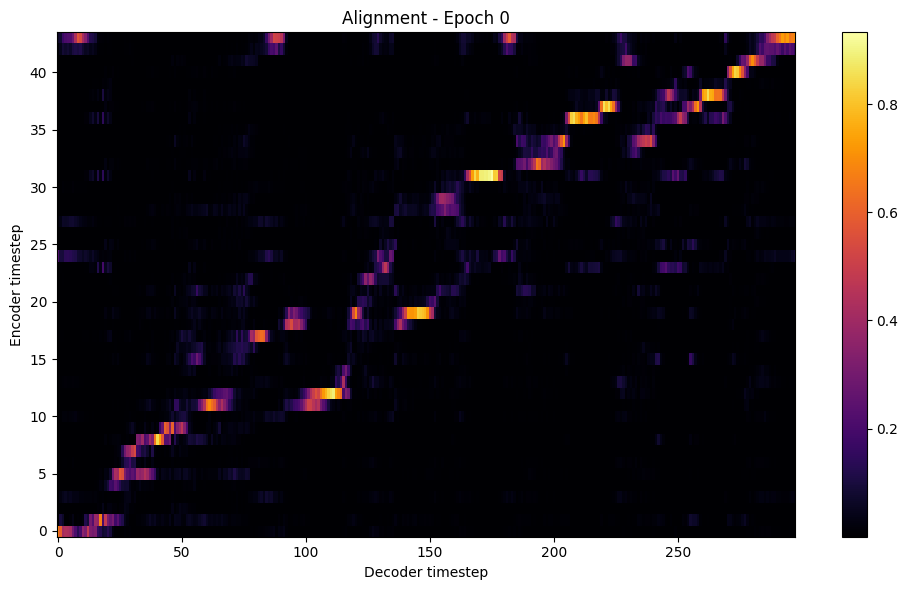

  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 1 Iteration: 18 Validation loss: 1.303384  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 2 Iteration: 27 Validation loss: 1.134223  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 3 Iteration: 36 Validation loss: 1.102078  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 4 Iteration: 45 Validation loss: 1.009304  Time: 0.4m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 5 Iteration: 54 Validation loss: 0.994341  Time: 0.4m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 6 Iteration: 63 Validation loss: 0.908240  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 7 Iteration: 72 Validation loss: 0.975711  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 8 Iteration: 81 Validation loss: 0.937204  Time: 0.4m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 9 Iteration: 90 Validation loss: 0.908755  Time: 0.3m LR: 0.000300
Saving model and optimizer state at iteration 90 to /content/drive/MyDrive/Colab Notebooks/TTS-TT3//model_BS_6_3e4_350
Model Saved (Checkpoint):  /content/drive/MyDrive/Colab Notebooks/TTS-TT3//model_BS_6_3e4_350


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 10 Iteration: 99 Validation loss: 0.941477  Time: 0.4m LR: 0.000300


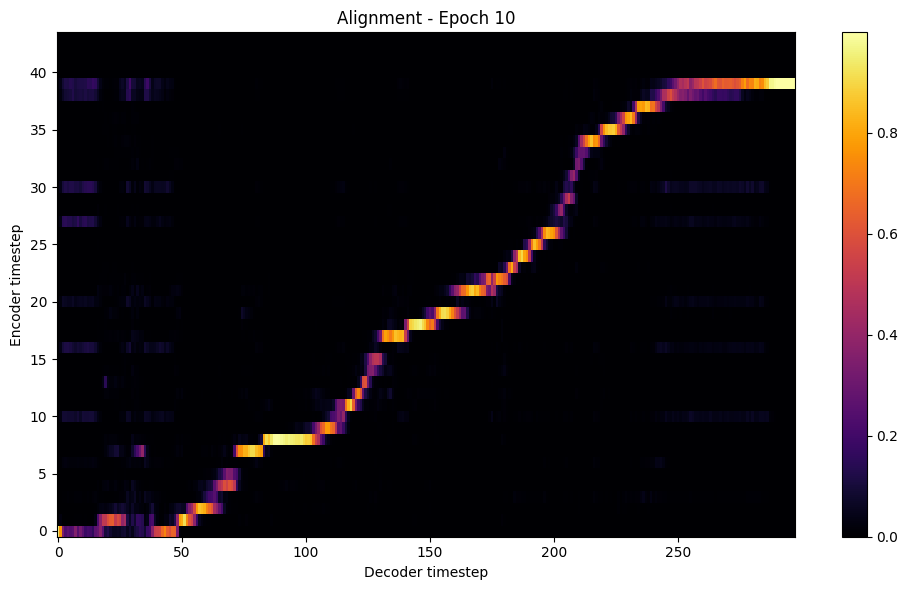

  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 11 Iteration: 108 Validation loss: 0.920192  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 12 Iteration: 117 Validation loss: 0.893297  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 13 Iteration: 126 Validation loss: 0.930876  Time: 0.4m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 14 Iteration: 135 Validation loss: 0.970950  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 15 Iteration: 144 Validation loss: 0.964683  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 16 Iteration: 153 Validation loss: 0.975799  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 17 Iteration: 162 Validation loss: 0.989088  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 18 Iteration: 171 Validation loss: 1.013113  Time: 0.4m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 19 Iteration: 180 Validation loss: 1.037154  Time: 0.4m LR: 0.000300
Saving model and optimizer state at iteration 180 to /content/drive/MyDrive/Colab Notebooks/TTS-TT3//model_BS_6_3e4_350
Model Saved (Checkpoint):  /content/drive/MyDrive/Colab Notebooks/TTS-TT3//model_BS_6_3e4_350


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 20 Iteration: 189 Validation loss: 1.024053  Time: 0.4m LR: 0.000300


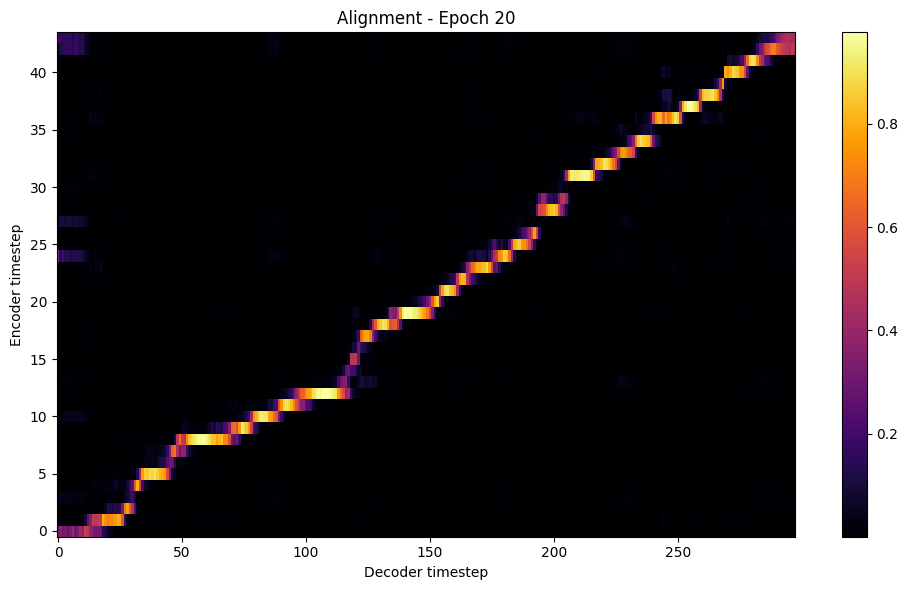

  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 21 Iteration: 198 Validation loss: 1.079162  Time: 0.3m LR: 0.000300


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch: 22 Iteration: 207 Validation loss: 1.093065  Time: 0.3m LR: 0.000300
Early stopping triggered at epoch 22


In [47]:
#@markdown ## <font color="pink"> **4. Training the model.**
#@markdown ___

#@markdown ### How often to save (Number of epochs)
#@markdown `10` by default.
save_interval =  10#@param {type: "integer"}
#@markdown  \

#@markdown ### How often to backup (number of epochs)
#@markdown `-1` (disabled) by default.
backup_interval =  -1#@param {type: "integer"}
#@markdown  \

print('checkpoint_path: ', checkpoint_path)
print('hparams: ', hparams, '\n')


train(
    output_directory,
    log_directory,
    checkpoint_path,
    warm_start,
    n_gpus,
    rank,
    group_name,
    hparams,
    log_directory2,
    save_interval,
    backup_interval
    )

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Texte:  Hello, this is a text-to-speech test.
Text to Tokens:  ['the', 'little', 'bunny', 'hopped', 'through', 'the', 'forest', 'looking', 'for', 'carrots', '.', 'once', 'upon', 'a', 'time', ',', 'there', 'was', 'a', 'magical', 'kingdom', 'in', 'the', 'clouds', '.', 'the', 'friendly', 'bear', 'waved', 'hello', 'to', 'all', 'the', 'animals', 'in', 'the', 'wood', '.', 'every', 'night', ',', 'the', 'twinkling', 'stars', 'would', 'tell', 'stories', 'in', 'the', 'sky', '.', 'the', 'rainbow', 'appeared', ',', 'showing', 'all', 'its', 'beautiful', 'colors', '.', 'ducks', 'love', 'to', 'splash', 'around', 'in', 'the', 'pond', 'during', 'summer', '.', 'the', 'curious', 'kitten', 'found', 'a', 'ball', 'of', 'yarn', 'and', 'played', 'all', 'day', '.', 'we', 'can', 'count', 'the', 'colorful', 'balloons', 'at', 'the', 'birthday', 'party', '.', 'let’s', 'go', 'on', 'a', 'treasure', 'hunt', 'in', 'the', 'backyard', '.', 'the', 'brave', 'astronaut', 'took', 'a', 'spaceship', 'to', 'the', 'moon', '.', 

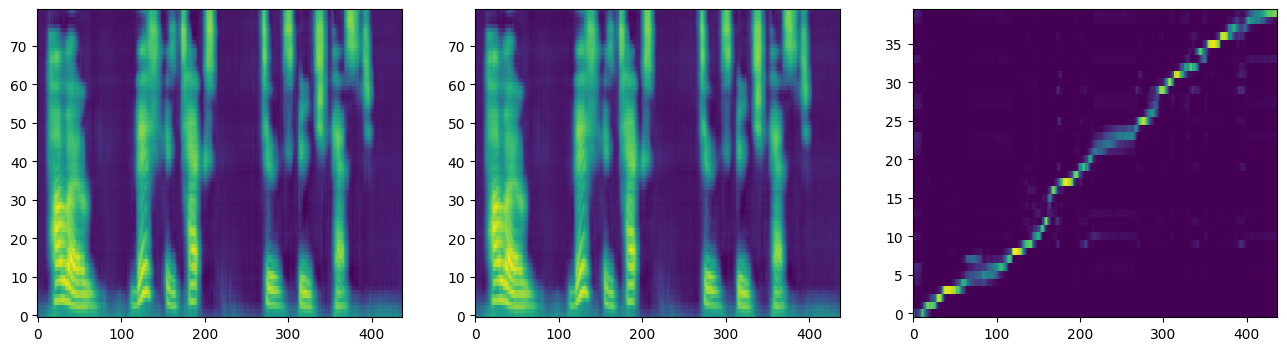

In [67]:
#@markdown ## <font color="pink"> **Test du modèle.**
#@markdown ---

# Import libraries and setup matplotlib
import torch
import numpy as np
import soundfile as sf
import IPython
# from IPython.display import Audio
from model import Tacotron2
from text import text_to_sequence, sequence_to_text

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from denoiser import Denoiser


def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower',
                       interpolation='none')

# Initialisation du modèle
# hparams = create_hparams()
# hparams.sampling_rate = 22050

# Load model from checkpoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/TTS-TT3/model_BS_6_3e4_350'   #.pth
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

# Load WaveGlow for mel2audio synthesis and denoiser
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
waveglow.cuda().eval().half()
denoiser = Denoiser(waveglow)

# Prepare text input
text = "Hello, this is a text-to-speech test."
tokens = text_to_tokens(texte)
sequence = text_to_sequence(text, ["cmudict_cleaners", "english_cleaners"])
phonemes = sequence_to_text(sequence)

print('Texte: ', text)
print('Text to Tokens: ', tokens)
print('Texte to Sequence: ', sequence)
print('Sequence to Texte: ', phonemes, '\n')

sequence = np.array(text_to_sequence(text, ["cmudict_cleaners", 'english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

# Decode text input and plot results
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

# Synthesize audio from spectrogram using WaveGlow
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

# (Optional) Remove WaveGlow bias
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)





In [69]:
# Telecharger un dosser
!zip -r /content/TTS-TT2/wavs.zip /content/TTS-TT2/wavs

#shutil.make_archive("/content/", 'zip', '/content/TTS-TT2/wavs')
#files.download('/content/processedwavs.zip')

  adding: content/TTS-TT2/wavs/ (stored 0%)
  adding: content/TTS-TT2/wavs/21.npy (deflated 42%)
  adding: content/TTS-TT2/wavs/15.wav (deflated 25%)
  adding: content/TTS-TT2/wavs/6.npy (deflated 35%)
  adding: content/TTS-TT2/wavs/37.npy (deflated 40%)
  adding: content/TTS-TT2/wavs/20.npy (deflated 28%)
  adding: content/TTS-TT2/wavs/31.npy (deflated 34%)
  adding: content/TTS-TT2/wavs/11.npy (deflated 37%)
  adding: content/TTS-TT2/wavs/18.npy (deflated 40%)
  adding: content/TTS-TT2/wavs/58.wav (deflated 26%)
  adding: content/TTS-TT2/wavs/28.npy (deflated 34%)
  adding: content/TTS-TT2/wavs/46.wav (deflated 27%)
  adding: content/TTS-TT2/wavs/19.wav (deflated 25%)
  adding: content/TTS-TT2/wavs/25.wav (deflated 29%)
  adding: content/TTS-TT2/wavs/52.npy (deflated 36%)
  adding: content/TTS-TT2/wavs/13.npy (deflated 38%)
  adding: content/TTS-TT2/wavs/45.wav (deflated 25%)
  adding: content/TTS-TT2/wavs/6.wav (deflated 23%)
  adding: content/TTS-TT2/wavs/1.npy (deflated 31%)
  add